In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from os import path
import os
from astropy.io import fits
from sklearn.metrics import mean_squared_error

from spectrum import Spectrum, FitsSpectrum
from common import list_files, list_directories, tqdm

In [2]:
# dib_centra_list = [float(dib_file.replace('.ascii', '')) for dib_file in os.listdir('data/dibs')]
dib_centra_list=[5780,5797,6196,6379,6613,7224]

print(dib_centra_list)

[5780, 5797, 6196, 6379, 6613, 7224]


Observation date,Target,Expected center [Å],Center [Å],Width,Amplitude,Skew,Slope,Start,RMSE,FWHM [Å],EW [Å]
2015-09-20T01:47:39.845,HD185859,5780,5780.02,0.62475,0.128156,-0.252045,-0.00244501,15.129,0.00601392,1.47117,0.290549
2015-09-20T01:47:39.845,HD185859,5797,5796.99,0.217856,0.181305,0.569877,-0.0147195,86.3177,0.0120625,0.513011,0.156341
2015-09-20T01:47:39.845,HD185859,6196,6196,0.14986,0.0230908,2.28489,-0.00197349,13.2336,0.0018685,0.352894,0.0437456
2015-09-20T01:47:39.845,HD185859,6379,6379.02,0.155645,0.25531,-0.236078,0.00627219,-38.9943,0.0124052,0.366516,0.141008
2015-09-20T01:47:39.845,HD185859,6613,6612.98,0.347206,0.116439,-1.17239,-0.00632746,42.8711,0.0164695,0.817607,0.208861
2016-08-14T01:36:06.410,HD185859,5780,5780.02,0.624215,0.126875,-0.272547,-0.00226453,14.082,0.00582631,1.46991,0.289519
2016-08-14T01:36:06.410,HD185859,5797,5797,0.21682,0.181185,0.567773,-0.0136101,79.8835,0.012601,0.510573,0.155922
2016-08-14T01:36:06.410,HD185859,6196,6196,0.14838,0.0284749,2.07758,-0.00239945,15.8716,0.00175766,0.349408,0.0444924
2016-08-14T01:36:06.410,HD185859,6379,6379.02,0.157693,0.252262,-0.290281,0.00556206,-34.4601,0.0124814,0.37134,0.141835
2016-08-14T01:36:06.410,HD185859,6613,6612.98,0.352965,0.114368,-1.19494,-0.0053928,36.6874,0.0160376,0.831168,0.212103


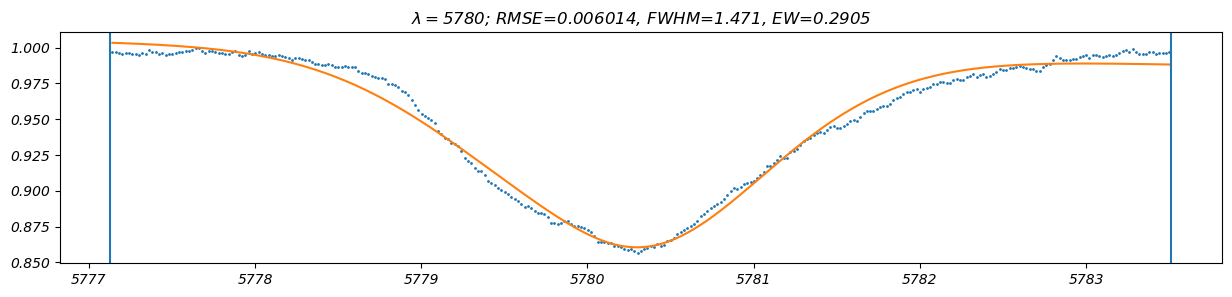

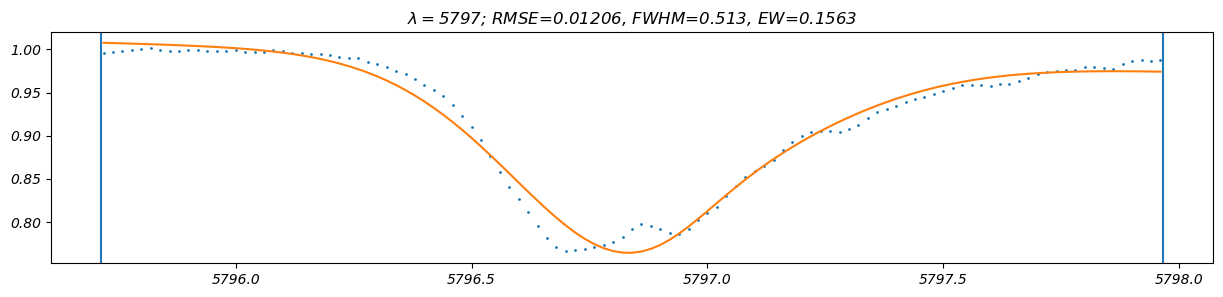

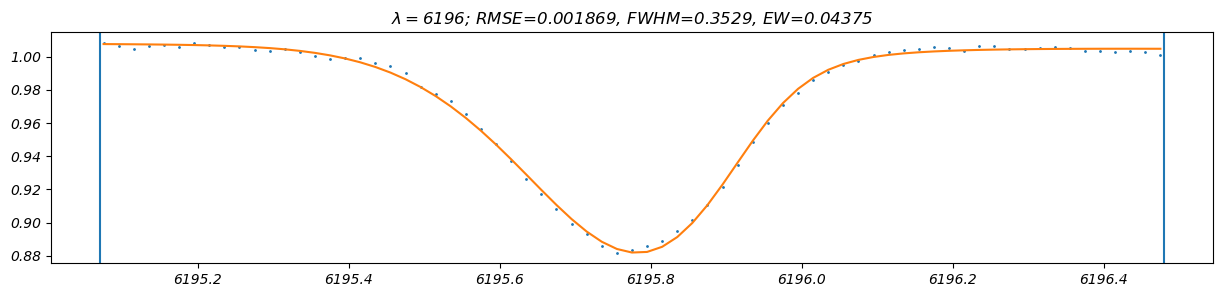

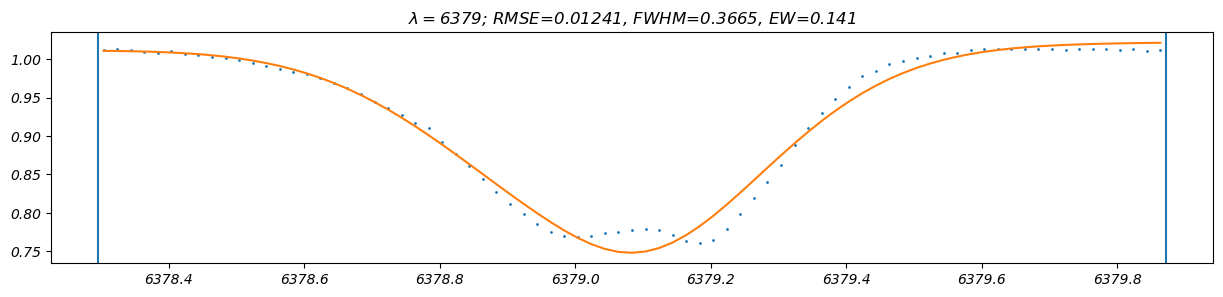

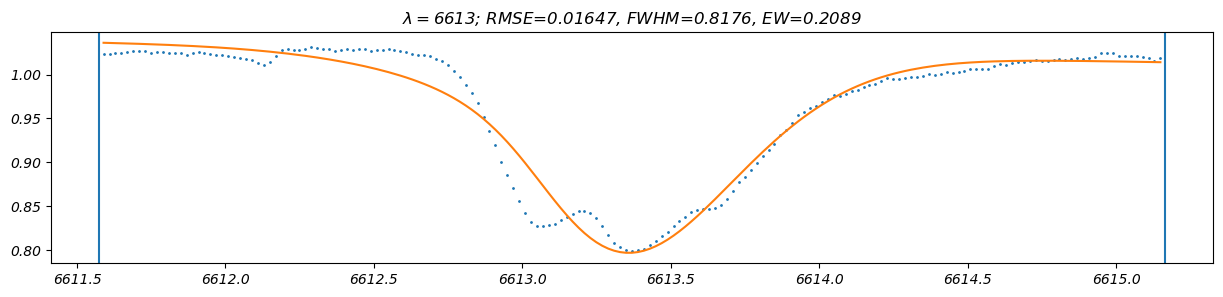

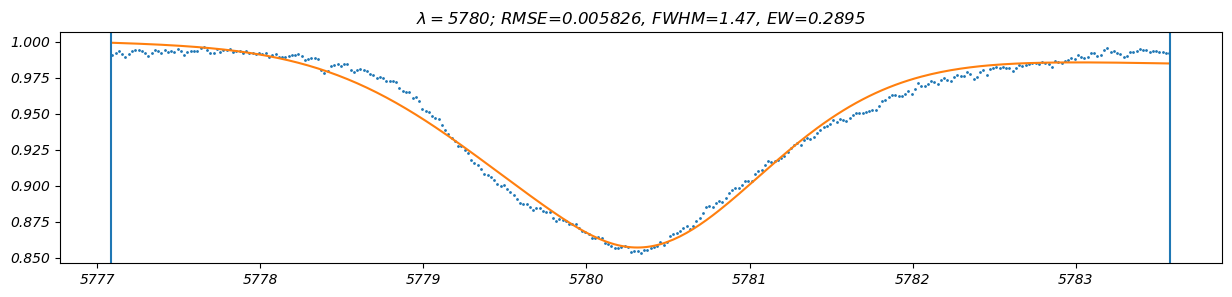

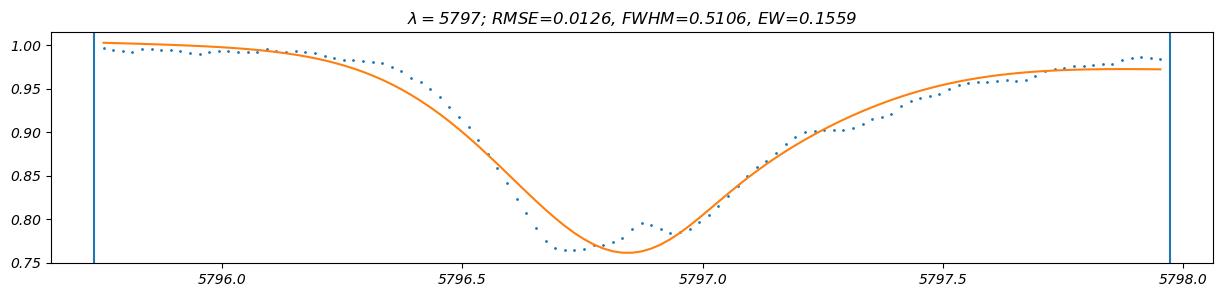

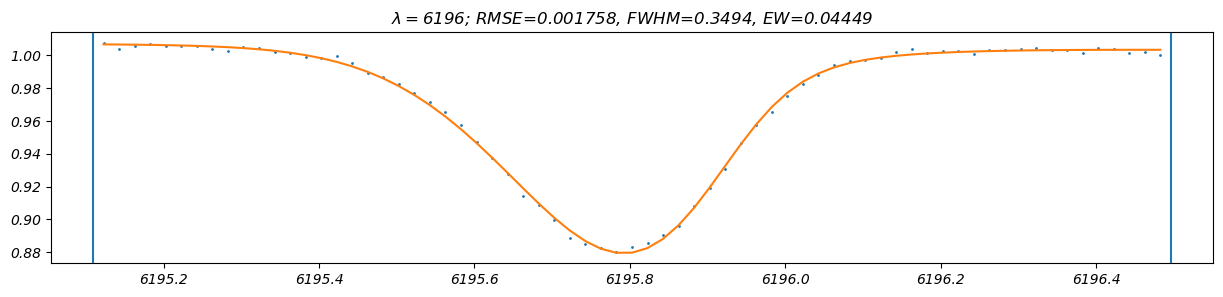

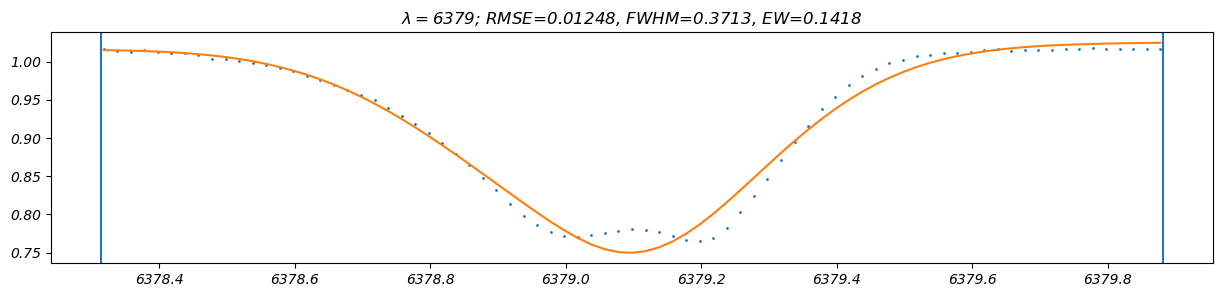

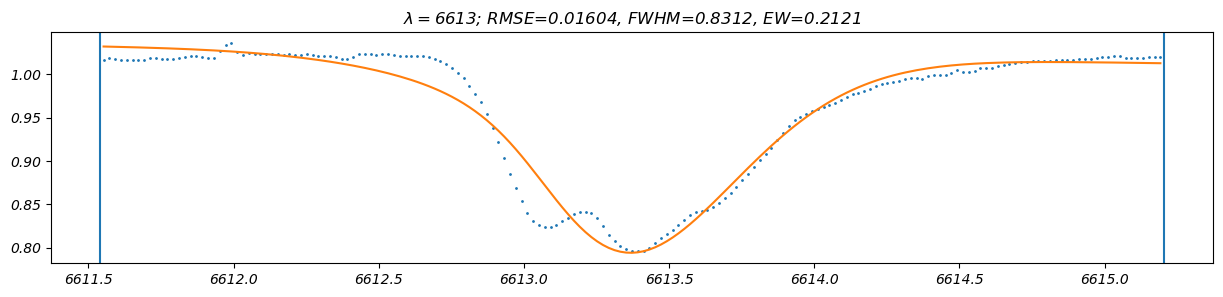

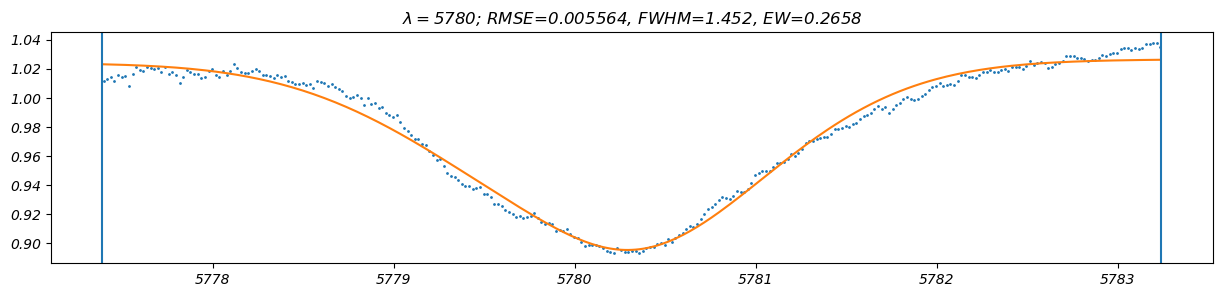

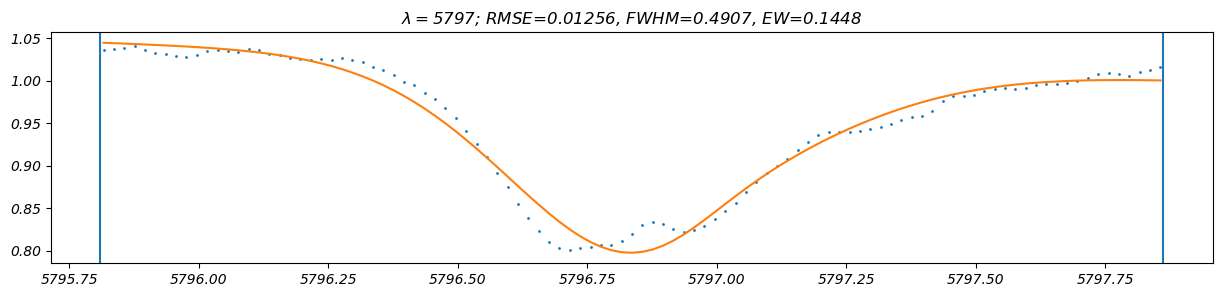

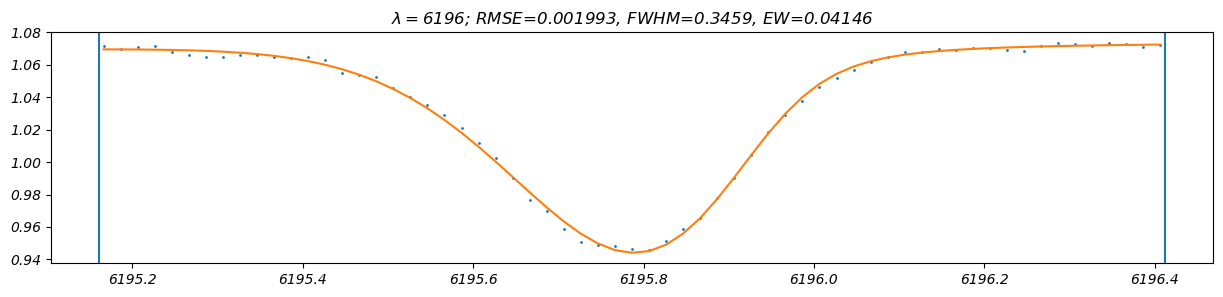

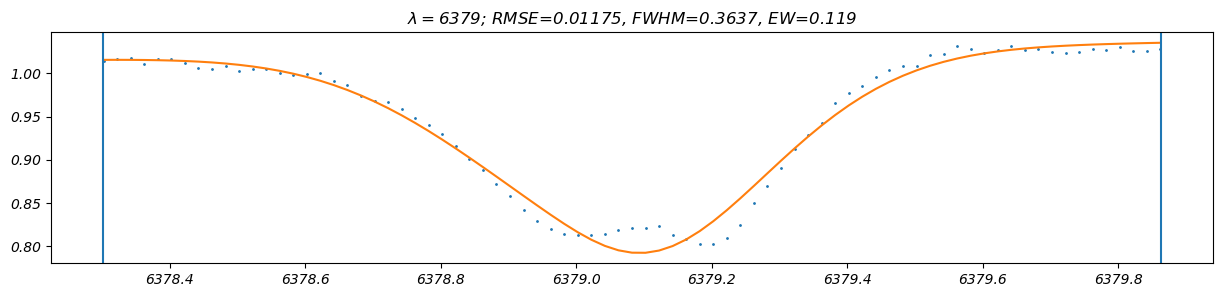

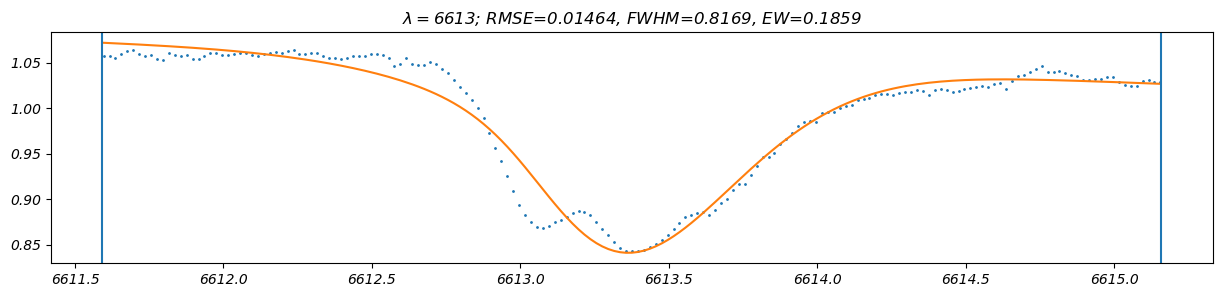

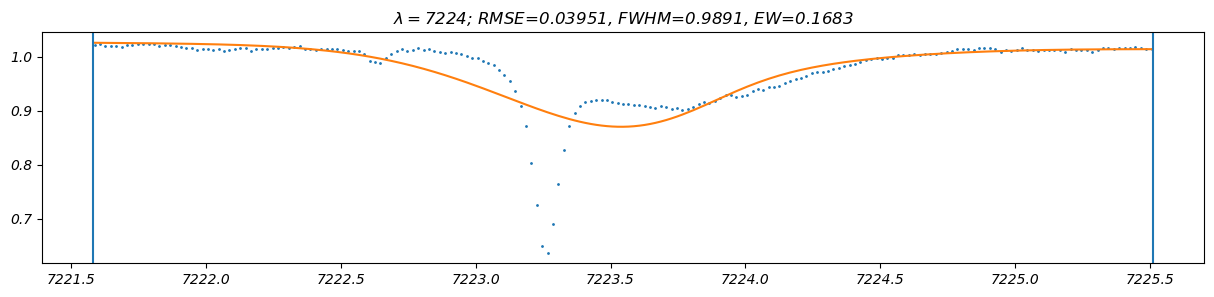

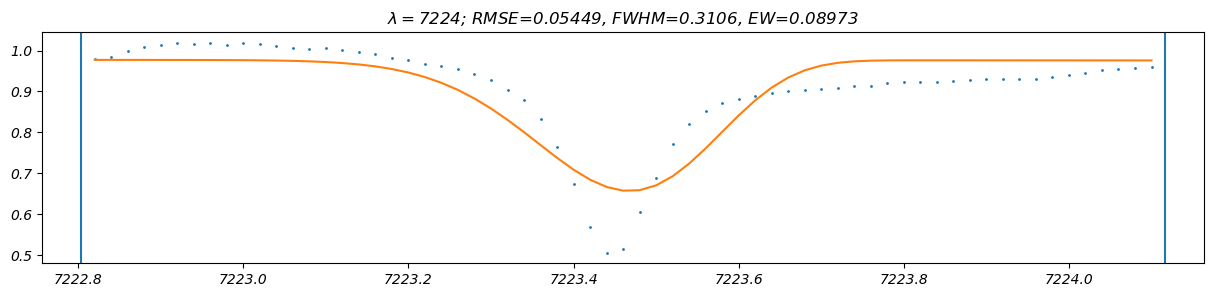

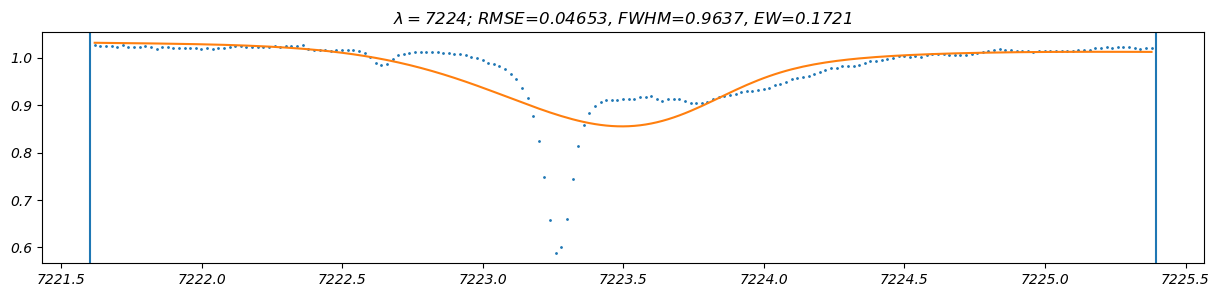

In [22]:
def load_target(target_dir: str) -> list[FitsSpectrum]:
    return [FitsSpectrum(datafile) for band_dir in list_directories(target_dir) for datafile in list_files(band_dir)]

hd185859 = load_target('data/fits/HD185859')
table_headers = ['Observation date', 'Target', 'Expected center [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'Slope', 'Start', 'RMSE', 'FWHM [Å]', 'EW [Å]']
table_data = []

for subspectrum in hd185859:
    subspectrum.remove_outliers()
    subspectrum.normalize(max_degree=10)
    subspectrum.correct_shift()

    wvl_max, wvl_min = np.max(subspectrum.wavelength), np.min(subspectrum.wavelength)
    for center in dib_centra_list:
        # The DIB does not lie in this subspectrum
        if not wvl_min < center < wvl_max:
            continue

        fig, ax = plt.subplots(1, 1, figsize=(15, 3))
        result = subspectrum.select_dib(center, ax=ax)

        if result is None:
            continue

        _, params, rmse, fwhm, ew, is_double = result
        table_data.append([subspectrum.obs_date, subspectrum.target, center, *params, rmse, fwhm, ew])

tabulate(table_data, table_headers, tablefmt='html')

In [25]:
np.sum([[1, 2, 3], [1, 2, 3]], axis=1)

array([6, 6])

In [ ]:
table_headers = ['Observation date', 'Target', 'Expected center [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'Slope', 'Start', 'RMSE', 'FWHM [Å]', 'EW [Å]']
table_data = []

def fit_gaussian_for_target(target: str):
    subspectra = load_target(f'data/fits/{target}')
    
    for subspectrum in subspectra:
        subspectrum.remove_outliers()
        subspectrum.normalize(max_degree=10)
        subspectrum.correct_shift()

        wvl_max, wvl_min = np.max(subspectrum.wavelength), np.min(subspectrum.wavelength)
        for center in dib_centra_list:
            # The DIB does not lie in this subspectrum
            if not wvl_min < center < wvl_max:
                continue

            result = subspectrum.select_dib(center)

            if result is None:
                continue

            _, params, rmse, fwhm, ew = result
            table_data.append([subspectrum.obs_date, subspectrum.target, center, *params, rmse, fwhm, ew])

for target in ['HD147889', 'HD170740', 'HD185859']:
    fit_gaussian_for_target(target)

np.savetxt('out/gaussian_fits_selected.txt', table_data, fmt='%s')
tabulate(table_data, table_headers, tablefmt='html')

In [ ]:
table_data = []
for target in os.listdir('data/fits'):
    fit_gaussian_for_target(target)

np.savetxt('out/gaussian_fits_all.txt', table_data, fmt='%s')